In [1]:
# %%
# autoreload
# %load_ext autoreload

# %autoreload 2
import math
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
import torch
import xgboost as xgb
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabModel, TabNetClassifier, TabNetRegressor
from sklearn.metrics import f1_score, precision_score, recall_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from app.constants import DATA_DIR, MODELS_DIR

## Data Exploration

In [15]:
activity_df = pd.read_csv(DATA_DIR / "raw_learning_activity.csv")
learner_df = pd.read_csv(DATA_DIR / "learner_details.csv")
content_df = pd.read_csv(DATA_DIR / "content_description.csv")

# rename columns to snake_case
for df in [activity_df, learner_df, content_df]:
    df.columns = df.columns.str.lower().str.replace(" ", "_")

# parse comma separated ints from `foreground_duration` column
activity_df.foreground_duration = activity_df.foreground_duration.str.replace(",", "").astype(int)

activity_df.play_time = pd.to_datetime(activity_df.play_time)

# remove leading and trailing whitespaces from `strand` and `learning_unit` column
activity_df.strand = activity_df.strand.str.strip()
activity_df.learning_unit = activity_df.learning_unit.str.strip()

One thing noticed was that activities that resulted in Error did not have a score nor foreground duration. We could consider filling them with sensible values but we assume that this is caused by the app and has nothing to do with the learner's performance. Therefore we drop these samples. 

In [16]:
print("Outcome distribution:")
activity_df[["outcome", "score"]].groupby("outcome").describe()

Outcome distribution:


score                                                    
                    count      mean       std  min    25%    50%     75%  max
outcome                                                                      
Abort              1198.0  0.181984  0.325635  0.0  0.000  0.000  0.2175  1.0
Error                 0.0       NaN       NaN  NaN    NaN    NaN     NaN  NaN
Success            2046.0  0.601777  0.297295  0.0  0.380  0.630  0.8800  1.0
TimeUp              264.0  0.129521  0.162832  0.0  0.049  0.071  0.1300  1.0
TimeoutInactivity   291.0  0.266248  0.357307  0.0  0.000  0.000  0.5000  1.0

In [17]:
activity_df = activity_df[activity_df.outcome != "Error"]

Among other metrics and aggregations of the data, one that caught my eye was the difference in scores depending on the strand:

In [18]:
activity_df.groupby("strand").score.describe()

,count,mean,std,min,25%,50%,75%,max
strand,,,,,,,,
Listening,2091.0,0.598895,0.341323,0.0,0.39,0.670,0.89,1.0
Reading,1708.0,0.180699,0.251632,0.0,0.00,0.071,0.25,1.0


My first approach is to train a model with the whole dataset but it is noted that training two separate models, one for each strand could be something to explore. 

Another curious insight was that the scores for each strand by learner are not strongly correlated. 

In [19]:
activity_df.groupby(["learner_id", "strand"]).score.mean().unstack().corr()

strand,Listening,Reading
strand,,
Listening,1.00000,0.15216
Reading,0.15216,1.00000


This supports the previous finding of strands having different score distributions.

Let's look at the stats for each learning unit.

In [26]:
activity_df.groupby(["learning_unit"]).score.agg(["mean", "std", "skew"])

,mean,std,skew
learning_unit,,,
OneCourse:OC_PhraseSentenceType.4dd8,0.213431,0.230357,1.350195
OneCourse:OC_PhraseSentenceType.5d44,0.250821,0.294683,1.246349
OneCourse:OC_PhraseSentenceType.5dd1,0.167483,0.282194,2.021695
OneCourse:OC_PhraseSentenceType.71cf,0.144887,0.224818,2.052975
OneCourse:OC_PhraseSentenceType.7864,0.150600,0.237820,2.103862
OneCourse:OC_PhraseSentenceType.9b09,0.191657,0.252551,1.458086
OneCourse:OC_PhraseSentenceType.df02,0.189591,0.263282,1.827338
OneCourse:OC_TalkingHead.1dac,0.692327,0.320873,-1.130598
OneCourse:OC_TalkingHead.2360,0.539200,0.355159,-0.347478


The standard deviation of the scores is somewhat high for most learning units. 

In [20]:
# %%
activity_df = pd.read_parquet(DATA_DIR / "learning_activity.parquet")
print("Available columns:", list(activity_df.columns))

Available columns: ['learner_id', 'school_id', 'class_id', 'session_id', 'play_time', 'learning_unit', 'strand', 'outcome', 'foreground_duration', 'score', 'school_type', 'gender', 'grade', 'id']


## Modeling

 We have to be careful on which features we use for training. Not all of them would be available during prediction time.

 For example, when we want to predict a learner's score at a given session, we won't have its `outcome` and `foreground_duration`,

 only past ones. For this reason, we take extra care during our feature engineering to only calculate aggregates of

 these columns and past scores using samples from previous activities.



 In production, calculating these features would be done by a pipeline job on certain schedule and saved

 in a feature storage. They are then retrieved during inference time.

In [3]:
# %%
def _perform_feature_engineering(activity_df: pd.DataFrame):
    # Add aggregates of from earlier `play_times` to each row
    for row_index, row in activity_df.iterrows():
        play_time = row.play_time
        activity_df.loc[row_index, "play_time_hour"] = play_time.hour
        activity_df.loc[row_index, "play_time_weekday"] = play_time.weekday()

        # Adding learning unit-specific historical features
        past_activity_df = activity_df[activity_df.play_time < play_time]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_activity_df,
            row_index=row_index,
            col_prefix="unit_past",
        )

        # Adding learner-specific historical features, globally, by strand, and by learning unit.
        past_learner_activity_df = past_activity_df[past_activity_df.learner_id == row.learner_id]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_learner_activity_df,
            row_index=row_index,
            col_prefix="learner_past",
        )

        past_strand_activity_df = past_learner_activity_df[past_learner_activity_df.strand == row.strand]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_strand_activity_df,
            row_index=row_index,
            col_prefix="learner_past_strand",
        )

        past_learning_unit_activity_df = past_strand_activity_df[
            past_strand_activity_df.learning_unit == row.learning_unit
        ]
        _add_agg_features_from_df(
            activity_df=activity_df,
            from_df=past_learning_unit_activity_df,
            row_index=row_index,
            col_prefix="learner_past_learning_unit",
        )


def _add_agg_features_from_df(activity_df: pd.DataFrame, from_df: pd.DataFrame, row_index: int, col_prefix: str):
    for agg_function in ["mean", "min", "max"]:
        activity_df.loc[row_index, f"{col_prefix}_scores_{agg_function}"] = from_df.score.agg(agg_function)
        activity_df.loc[row_index, f"{col_prefix}_foreground_durations_{agg_function}"] = (
            from_df.foreground_duration.agg(agg_function)
        )

    for outcome in activity_df.outcome.unique():
        is_outcome = from_df.outcome == outcome

        outcome_count = is_outcome.sum()
        col_name = f"{col_prefix}_{outcome.lower()}_count"
        activity_df.loc[row_index, col_name] = outcome_count

        past_outcome_rate = outcome_count / (len(is_outcome) + 1e-6)
        col_name = f"{col_prefix}_{outcome.lower()}_rate"
        activity_df.loc[row_index, col_name] = past_outcome_rate

In [66]:
# %%
_perform_feature_engineering(activity_df)

categorical_columns = [
    "class_id",
    "school_id",
    "school_type",
    "learning_unit",
    "strand",
    "play_time_hour",
    "play_time_weekday",
    "gender",
    "grade",
]
numerical_columns = [column for column in activity_df.columns if "past_" in column]

 Before doing anything else, we keep a testing set to ensure there's no data leakage.

 Although we took care that data leakeage doesn't occur during feature engineering,

Any adjustments to the data that happen during modeling should only be performed on the training set.



 We use `play_time` as the splitting feature to be extra careful. Testing and validation sets each contain 10% of the samples.

In [67]:
# %%
def _split_dataset(activity_df: pd.DataFrame, test_split_datetime: pd.Timestamp, val_split_datetime: pd.Timestamp):
    train_activity_df = activity_df[activity_df.play_time < val_split_datetime]
    val_activity_df = activity_df[
        (activity_df.play_time >= val_split_datetime) & (activity_df.play_time < test_split_datetime)
    ]
    test_activity_df = activity_df[activity_df.play_time >= test_split_datetime]

    columns = ["learner_id", "class_id", "school_id", "school_type", "learning_unit", "strand", "grade"]
    for df in [val_activity_df, test_activity_df]:
        for column in columns:
            # print the number of unseen values in the test set
            print(f"Number of unseen `{column}` in the set: {len(set(df[column]) - set(train_activity_df[column]))}")
    return train_activity_df, val_activity_df, test_activity_df


astype_dict = {col: "category" for col in categorical_columns}
activity_df = activity_df.astype(astype_dict)

test_split_datetime = activity_df.play_time.quantile(0.9)
val_split_datetime = activity_df.play_time.quantile(0.8)
train_activity_df, val_activity_df, test_activity_df = _split_dataset(
    activity_df, test_split_datetime, val_split_datetime
)

Number of unseen `learner_id` in the set: 8
Number of unseen `class_id` in the set: 1
Number of unseen `school_id` in the set: 0
Number of unseen `school_type` in the set: 0
Number of unseen `learning_unit` in the set: 0
Number of unseen `strand` in the set: 0
Number of unseen `grade` in the set: 0
Number of unseen `learner_id` in the set: 13
Number of unseen `class_id` in the set: 2
Number of unseen `school_id` in the set: 1
Number of unseen `school_type` in the set: 0
Number of unseen `learning_unit` in the set: 0
Number of unseen `strand` in the set: 0
Number of unseen `grade` in the set: 0


 A few of the samples in the validation and testing set contain learners, classes, and schools not seen

 in the training set. This could cause problems because these are categorical features. XGBoost is capable

 of dealing with unseen categories but TabNet is not.

In [68]:
def _prepare_datasets(
    activity_dfs: list[pd.DataFrame],
    categorical_columns: list[str],
    numerical_columns: list[str],
    label_column: str,
):
    feature_columns = categorical_columns + numerical_columns
    astype_dict = {col: "category" for col in categorical_columns}
    features_and_labels = []
    for activity_df in activity_dfs:
        feature_df = activity_df[feature_columns].astype(astype_dict)
        labels = activity_df[label_column]
        features_and_labels.append((feature_df, labels))

    return features_and_labels


def _run_grid_search(
    xbg_model: xgb.XGBModel,
    param_grid: dict,
    train_feature_df: pd.DataFrame,
    val_feature_df: pd.DataFrame,
    train_labels: pd.Series,
    val_labels: pd.Series,
    scoring: str,
):
    clf = GridSearchCV(
        xbg_model,
        param_grid=param_grid,
        n_jobs=8,
        scoring=scoring,
        return_train_score=True,
    )
    eval_set = [
        (val_feature_df, val_labels),
    ]
    clf.fit(train_feature_df, train_labels, eval_set=eval_set, verbose=0)
    return clf

In [69]:
(train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
    [train_activity_df, val_activity_df, test_activity_df],
    categorical_columns,
    numerical_columns,
    label_column="score",
)

In [70]:
regressor = xgb.XGBRegressor(enable_categorical=True, validate_parameters=True)
param_grid = {
    "max_depth": [1, 2, 4],
    "subsample": [0.8],
    "min_child_weight": [0, 1],
    "gamma": [0, 0.2, 1, 5],
    "max_delta_step": [0, 1],
    "n_estimators": [50, 100, 150],
    "learning_rate": [0.1],
    "tree_method": ["hist"],
}
param_combinations = math.prod([len(param) for param in param_grid.values()])
print(f"Number of combinations: {param_combinations}")
print(f"Estimated time: {param_combinations*2/60} minutes")

clf = _run_grid_search(
    xbg_model=regressor,
    param_grid=param_grid,
    train_feature_df=train_feature_df,
    val_feature_df=val_feature_df,
    train_labels=train_labels,
    val_labels=val_labels,
    scoring="neg_root_mean_squared_error",
)
print("best_params:", clf.best_params_)
regressor = clf.best_estimator_

Number of combinations: 144
Estimated time: 4.8 minutes


best_params: {'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 0, 'n_estimators': 50, 'subsample': 0.8, 'tree_method': 'hist'}


In [71]:
# %%
train_pred_labels = regressor.predict(train_feature_df)
train_rmse = root_mean_squared_error(train_labels, train_pred_labels)
print(f"Training set RMSE: {train_rmse:0.3f}")

val_pred_labels = regressor.predict(val_feature_df)
val_rmse = root_mean_squared_error(val_labels, val_pred_labels)
print(f"Validation set RMSE: {val_rmse:0.3f}")

test_pred_labels = regressor.predict(test_feature_df)
test_rmse = root_mean_squared_error(test_labels, test_pred_labels)
print(f"Testing set RMSE: {test_rmse:0.3f}")

Training set RMSE: 0.214
Validation set RMSE: 0.341
Testing set RMSE: 0.325


 It seems the model is overfitting.

 Using the cv_results, we can dig deeper into the correlation between the hyperparameters and the scores.

In [72]:
cv_result_df = pd.DataFrame(clf.cv_results_)
param_columns = [
    column for column in cv_result_df.columns if column.startswith("param_") and column != "param_tree_method"
]
score_columns = ["mean_train_score", "mean_test_score"]
cv_result_df[[*param_columns, *score_columns]].corr()[score_columns].astype(float).round(3)

,mean_train_score,mean_test_score
param_gamma,-0.533,-0.803
param_learning_rate,NaN,NaN
param_max_delta_step,-0.000,0.001
param_max_depth,0.626,0.361
param_min_child_weight,0.000,0.000
param_n_estimators,0.153,0.016
param_subsample,NaN,NaN
mean_train_score,1.000,0.545
mean_test_score,0.545,1.000


Given more time, we could go into further hyperparameter tuning but the improvement seems limited
given that the lowest training RMSE is still high.

With this high RMSE, we can see the model struggles to predict an accurate score for a student
given its historical activity. With XGBoost, we can see the importance of each feature to the model.

We look at the "gain" score of each feature. In practice, "gain" is often more informative than "weight"
as it provides a deeper insight into how much a feature contributes to enhancing the model's predictions,
making it a good choice for most  to understand how effective it is.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature Gain', ylabel='Features'>

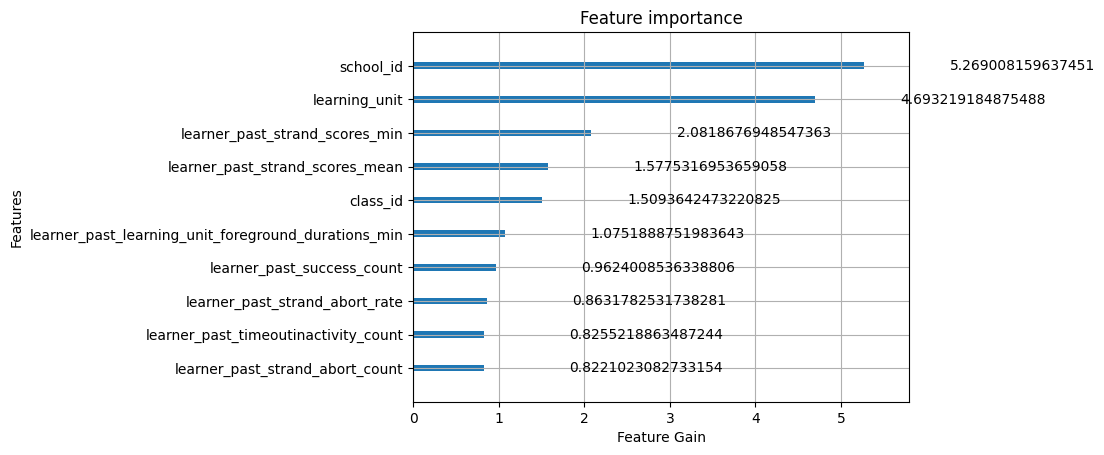

In [73]:
# %%
xgb.plot_importance(
    clf.best_estimator_.get_booster(),
    max_num_features=10,
    importance_type="gain",
    xlabel="Feature Gain",
)

We see that the top 2 features with most gain are not related to the learning activity. In fact, `learning_unit`
has the highest gain, meaning that the learning units themselves have more influence on a student's
score than the student's current skill.

Are there `learning_units` where the student's past performance is more indicative of their likely score?

In [74]:
# %%
for learning_unit in sorted(activity_df.learning_unit.unique()):
    lu_test_samples_index = test_feature_df[test_feature_df.learning_unit == learning_unit].index

    lu_test_feature_df = test_feature_df.loc[list(lu_test_samples_index)]
    lu_test_labels = test_labels.loc[list(lu_test_samples_index)]

    test_pred_labels = regressor.predict(lu_test_feature_df)
    test_rmse = root_mean_squared_error(lu_test_labels, test_pred_labels)
    print(f"learning_unit={learning_unit} (n={len(lu_test_labels)}) RMSE: {test_rmse:0.3f}")

learning_unit=OneCourse:OC_PhraseSentenceType.4dd8 (n=21) RMSE: 0.200
learning_unit=OneCourse:OC_PhraseSentenceType.5d44 (n=16) RMSE: 0.213
learning_unit=OneCourse:OC_PhraseSentenceType.5dd1 (n=48) RMSE: 0.232
learning_unit=OneCourse:OC_PhraseSentenceType.71cf (n=31) RMSE: 0.158
learning_unit=OneCourse:OC_PhraseSentenceType.7864 (n=69) RMSE: 0.238
learning_unit=OneCourse:OC_PhraseSentenceType.9b09 (n=17) RMSE: 0.244
learning_unit=OneCourse:OC_PhraseSentenceType.df02 (n=29) RMSE: 0.312
learning_unit=OneCourse:OC_TalkingHead.1dac (n=18) RMSE: 0.452
learning_unit=OneCourse:OC_TalkingHead.2360 (n=21) RMSE: 0.476
learning_unit=OneCourse:OC_TalkingHead.23de (n=25) RMSE: 0.503
learning_unit=OneCourse:OC_TalkingHead.3dba (n=15) RMSE: 0.278
learning_unit=OneCourse:OC_TalkingHead.5352 (n=26) RMSE: 0.349
learning_unit=OneCourse:OC_TalkingHead.5a16 (n=12) RMSE: 0.390
learning_unit=OneCourse:OC_TalkingHead.a5dd (n=19) RMSE: 0.476
learning_unit=OneCourse:OC_TalkingHead.ce7e (n=13) RMSE: 0.418


 We see that the RMSE for all Reading learning units are between 0.16 and 0.32,
while the RMSE for all Listening learning units are between 0.26 and 0.44.

The model is better at predicting Reading performance.

It's worth mentioning that I've tried training two models, splitting the data by strand,
but the overall results were similar to the combined model, only slightly worse. So 
there is some predicting power between strands with this model even if their score
distributions are different.

In [75]:
# %% Save the model for later use
regressor_path = Path(MODELS_DIR / "xgboost_regressor.json")
regressor_path.parent.mkdir(parents=True, exist_ok=True)
regressor.save_model(regressor_path)
df = pd.concat([train_activity_df, val_activity_df, test_activity_df])
df.to_parquet(DATA_DIR / "processed_learning_activity.parquet")

 ### Using TabNet

TabNet is a deep learning model that promises to choose features depending on the sample.

It's a good model to use when we have a lot of features and we want to avoid overfitting.

 TabNet cannot deal with unseen categories in the data. We have to make sure that the validation and testing set
only contain categories that are present in the training set. Let's print the categories that don't fit this criteria.

Throwing away data is not ideal given our small dataset. There are around 100 rows total from the validation and
testing sets that contain unseen categories, dropping them would mean reducing each by ~15%. We pick a random class_id from the training set

In [81]:
train_feature_df.describe()

,unit_past_scores_mean,unit_past_foreground_durations_mean,unit_past_scores_min,unit_past_foreground_durations_min,unit_past_scores_max,unit_past_foreground_durations_max,unit_past_success_count,unit_past_success_rate,unit_past_abort_count,unit_past_abort_rate,...,learner_past_learning_unit_scores_max,learner_past_learning_unit_foreground_durations_max,learner_past_learning_unit_success_count,learner_past_learning_unit_success_rate,learner_past_learning_unit_abort_count,learner_past_learning_unit_abort_rate,learner_past_learning_unit_timeoutinactivity_count,learner_past_learning_unit_timeoutinactivity_rate,learner_past_learning_unit_timeup_count,learner_past_learning_unit_timeup_rate
count,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3038.000000,3039.000000,3039.000000,3039.000000,3039.000000,...,1009.000000,1009.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000,3039.000000
mean,0.496837,134466.080258,0.000043,1443.612574,0.997113,452175.742265,943.969398,0.651355,371.838105,0.222418,...,0.277946,147640.456888,0.037841,0.026571,0.329385,0.200477,0.086871,0.051387,0.083251,0.053581
std,0.059309,9496.572673,0.002359,5464.252168,0.048244,7859.850182,497.996588,0.067169,256.799415,0.050474,...,0.356035,129459.605735,0.205782,0.149686,0.697802,0.382816,0.349488,0.202958,0.321461,0.208367
min,0.057600,123098.880503,0.000000,681.000000,0.130000,293791.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,681.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.464612,132878.606844,0.000000,681.000000,1.000000,448561.000000,536.000000,0.614449,136.000000,0.187970,...,0.000000,24556.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.486540,133627.969067,0.000000,1333.000000,1.000000,448647.000000,975.000000,0.638579,335.000000,0.223582,...,0.077000,129693.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.529741,135416.143259,0.000000,1756.000000,1.000000,448647.000000,1404.000000,0.693106,570.000000,0.252174,...,0.500000,228061.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.686111,316467.400000,0.130000,293791.000000,1.000000,463776.000000,1724.000000,0.812121,886.000000,1.000000,...,1.000000,463776.000000,2.000000,1.000000,4.000000,1.000000,3.000000,1.000000,3.000000,1.000000


In [94]:
train_activity_df

,learner_id,school_id,class_id,session_id,play_time,learning_unit,strand,outcome,foreground_duration,score,...,learner_past_learning_unit_scores_max,learner_past_learning_unit_foreground_durations_max,learner_past_learning_unit_success_count,learner_past_learning_unit_success_rate,learner_past_learning_unit_abort_count,learner_past_learning_unit_abort_rate,learner_past_learning_unit_timeoutinactivity_count,learner_past_learning_unit_timeoutinactivity_rate,learner_past_learning_unit_timeup_count,learner_past_learning_unit_timeup_rate
0,100e325c952038afe247418e8d3dabea,2475250c1a2161e934a992047fdefd5e,d574c906d05f1a4c577ccccd71ab4ff7,db3ee4cb-ce41-433e-b7b4-6e70bb31d8c7,2023-09-12 09:57:00,OneCourse:OC_TalkingHead.5352,Listening,Success,322484,0.160,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,3b3db28b996fedc8f8569913d31b51b2,2475250c1a2161e934a992047fdefd5e,d574c906d05f1a4c577ccccd71ab4ff7,553953fd-b072-4e35-ae37-eb1b9426a73a,2023-09-12 07:22:00,OneCourse:OC_TalkingHead.2360,Listening,Success,94752,0.890,...,1.0,133588.0,2.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,ad790d0bf35b1abcfddbdd5704cfbaee,846b8e98464b88611faeb4d6c1b87e1b,44530f9f3628774cc1f95ebad97b1579,c8420418-b7c2-4b17-8cd1-747ef33583ba,2023-09-14 08:23:00,OneCourse:OC_TalkingHead.5352,Listening,Success,106277,0.700,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3,1ba9673c01ce80c66d2d4c744a3cab70,00b8a145665d361e0282fd8234909dbc,5252bfa9afc16bf344d2fa3b4c734d46,6360e886-4853-4011-8a9e-e0e62001f4e5,2023-09-09 16:56:00,OneCourse:OC_TalkingHead.ce7e,Listening,Abort,5682,0.000,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
5,4c079ed95d7da41fece4975ce8b25246,2a32133bfbb3d9e66f385d6965229ec8,5e3ff005367adfcfcaf84d2c9221f15f,991a881f-40b3-4f53-b441-1f803ebb0200,2023-09-12 11:23:00,OneCourse:OC_TalkingHead.5352,Listening,Success,130192,0.470,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,d49758f00706bc10ff834f52178d3644,14863a598e20d980fe3d0454c9c581e3,657b9098cc8f78d85db30bf90ee30d25,03f431fe-ae07-4446-890a-702ee21a430d,2023-09-28 17:07:00,OneCourse:OC_PhraseSentenceType.5d44,Reading,Success,279461,0.095,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3794,bc207f25fd6207b4e428ee59131eec6c,679ed119a5bc610c505aad01b7bf2f56,25a4f7a39263bb54ad4b0622e590a714,c4e6ca51-2352-4c3d-8731-963158a17901,2023-09-27 07:08:00,OneCourse:OC_TalkingHead.23de,Listening,Success,84784,0.900,...,NaN,NaN,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
3796,a906b890901d051e57a509aeebc5900c,cea71ed365b5a34b57966d2cc7ccda1d,21d87d9a6d11b43e82a32543bf94da37,51558c54-fcdd-4c3a-8530-82187d1ac6da,2023-10-06 11:23:00,OneCourse:OC_PhraseSentenceType.5dd1,Reading,Success,277042,0.180,...,0.0,190247.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.0,0.999999
3797,c049848f8fbe8da69664ffd0ccd5a41e,bc70f48ff22a29c3223ebe57af1e646c,7bb53a94b0dcff7db54126e7cfd2ae0b,8e6c918f-8ad7-4606-b6f1-cb3c46061727,2023-09-21 11:04:00,OneCourse:OC_TalkingHead.2360,Listening,Success,112023,1.000,...,0.0,159652.0,0.0,0.0,2.0,0.666666,1.0,0.333333,0.0,0.000000


In [88]:
# %%
def _prepare_tabnet_datasets(
    train_activity_df: pd.DataFrame,
    val_activity_df: pd.DataFrame,
    test_activity_df: pd.DataFrame,
    categorical_columns: list[str],
    numerical_columns: list[str],
    label_column: str,
):

    (train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
        [train_activity_df, val_activity_df, test_activity_df],
        categorical_columns,
        numerical_columns,
        label_column=label_column,
    )

    train_feature_df = train_feature_df.copy()
    val_feature_df = val_feature_df.copy()
    test_feature_df = test_feature_df.copy()
    categorical_dims = {}
    for col in categorical_columns:
        label_encoder = LabelEncoder()
        unique_values = pd.concat([train_feature_df[col], val_feature_df[col]]).unique()
        label_encoder.fit(unique_values)

        missing_in_test = set(test_feature_df[col].unique()) - set(unique_values)
        # NOTE: we circumvent the issue of unseen values in the test set but
        # there are better ways to handle this.
        if missing_in_test:
            # fill with a random category from training
            has_missing_category = test_feature_df[col].isin(missing_in_test)
            print(f"Warning: filling {has_missing_category.sum()} in {col} with a random category from training")
            test_feature_df.loc[has_missing_category, col] = np.random.choice(unique_values)

        train_feature_df[col] = label_encoder.transform(train_feature_df[col].values)
        val_feature_df[col] = label_encoder.transform(val_feature_df[col].values)
        test_feature_df[col] = label_encoder.transform(test_feature_df[col].values)
        categorical_dims[col] = len(label_encoder.classes_)

    for col in numerical_columns:
        # NOTE: this should be looked at, as it might not be the best way to handle missing values
        train_feature_df = train_feature_df.fillna(-1, axis=1)
        val_feature_df = val_feature_df.fillna(-1, axis=1)
        test_feature_df = test_feature_df.fillna(-1, axis=1)

    return (
        (train_feature_df.values, train_labels.values),
        (val_feature_df.values, val_labels.values),
        (test_feature_df.values, test_labels.values),
    )


def _fit_tabnet(
    tabnet_model: TabModel,
    train_samples: np.array,
    val_samples: np.array,
    train_labels: np.array,
    val_labels: np.array,
    eval_metric: str,
    unsupervised_model: Optional[TabNetPretrainer] = None,
):
    eval_set = [
        (train_samples, train_labels),
        (val_samples, val_labels),
    ]
    tabnet_model.fit(
        train_samples,
        train_labels,
        eval_set=eval_set,
        eval_name=["train", "val"],
        eval_metric=[eval_metric],
        from_unsupervised=unsupervised_model,
    )

In [93]:
# %%
(train_samples, train_labels), (val_samples, val_labels), (test_samples, test_labels) = _prepare_tabnet_datasets(
    train_activity_df,
    val_activity_df,
    test_activity_df,
    categorical_columns=categorical_columns,
    numerical_columns=numerical_columns,
    label_column="score",
)

unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), mask_type="entmax", verbose=0
)

unsupervised_model.fit(
    X_train=train_samples,
    eval_name=["train"],
    eval_set=[(train_samples)],
    max_epochs=1_000,
    pretraining_ratio=0.8,
)


Early stopping occurred at epoch 53 with best_epoch = 43 and best_train_unsup_loss_numpy = 22.73748016357422


/opt/miniconda3/envs/eidu/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


 If loss is below 1, according to the paper, the unsupervised model performs better

 than predicting the mean. We use it if that's the case.

In [85]:
# %%
regressor = TabNetRegressor(verbose=1)
_fit_tabnet(
    tabnet_model=regressor,
    train_samples=train_samples,
    val_samples=val_samples,
    train_labels=train_labels.reshape(-1, 1),
    val_labels=val_labels.reshape(-1, 1),
    eval_metric="rmse",
    # unsupervised_model=unsupervised_model,
)

/opt/miniconda3/envs/eidu/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.94889 | train_rmse: 26.74106| val_rmse: 31.70523|  0:00:00s
epoch 1  | loss: 0.68717 | train_rmse: 10.43153| val_rmse: 12.32831|  0:00:01s
epoch 2  | loss: 0.37725 | train_rmse: 12.49261| val_rmse: 7.83308 |  0:00:01s
epoch 3  | loss: 0.38392 | train_rmse: 7.67828 | val_rmse: 3.11527 |  0:00:01s
epoch 4  | loss: 0.29897 | train_rmse: 4.67987 | val_rmse: 1.95369 |  0:00:02s
epoch 5  | loss: 0.20327 | train_rmse: 2.54098 | val_rmse: 1.29826 |  0:00:02s
epoch 6  | loss: 0.20257 | train_rmse: 1.75685 | val_rmse: 0.80064 |  0:00:02s
epoch 7  | loss: 0.17744 | train_rmse: 1.37035 | val_rmse: 0.87449 |  0:00:03s
epoch 8  | loss: 0.15302 | train_rmse: 0.86545 | val_rmse: 0.68449 |  0:00:03s
epoch 9  | loss: 0.14224 | train_rmse: 0.79922 | val_rmse: 0.6683  |  0:00:03s
epoch 10 | loss: 0.14197 | train_rmse: 0.96691 | val_rmse: 0.92287 |  0:00:04s
epoch 11 | loss: 0.13341 | train_rmse: 0.91877 | val_rmse: 0.93596 |  0:00:04s
epoch 12 | loss: 0.12845 | train_rmse: 1.06802 | val

/opt/miniconda3/envs/eidu/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [64]:
# %%
train_pred_labels = regressor.predict(train_samples)
train_rmse = root_mean_squared_error(train_labels, train_pred_labels)
print(f"Training set RMSE: {train_rmse:0.3f}")

val_pred_labels = regressor.predict(val_samples)
val_rmse = root_mean_squared_error(val_labels, val_pred_labels)
print(f"Validation set RMSE: {val_rmse:0.3f}")

test_pred_labels = regressor.predict(test_samples)
test_rmse = root_mean_squared_error(test_labels, test_pred_labels)
print(f"Testing set RMSE: {test_rmse:0.3f}")

Training set RMSE: 0.799
Validation set RMSE: 0.668
Testing set RMSE: 0.939


 TabNet is not fitting the data well. The training, validation, and testing RMSE are all high and close to each other.

 XGBoost beats TabNet by 2% in RMSE, so from the results we have, we would choose XGBoost.

 ## Reframing as a classification problem



 Let's see if we can get better performance if we reframe the problem as a classification task.

 We divide the scores into bins that the model will predict for a given sample.

 If we can show that a model can predict a student's score as a range, then we can use this information more reliably.



 Let's check the score distribution to see how we can divide the scores into bins.

<Axes: >

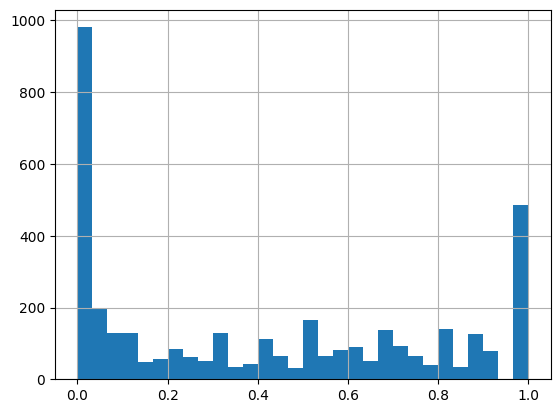

In [95]:
# %%
activity_df.score.hist(bins=30)

 Let's also check the distribution of the scores by dataset split.

<Axes: >

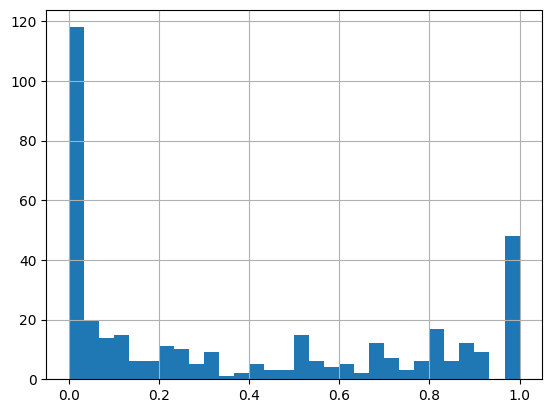

In [96]:
# %%
val_activity_df.score.hist(bins=30)

<Axes: >

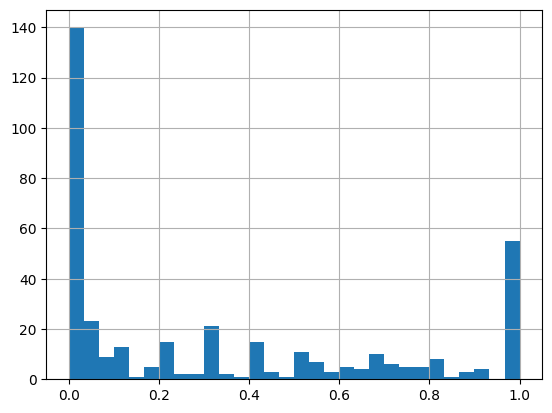

In [97]:
# %%
test_activity_df.score.hist(bins=30)

 Due to time constraints, I decided to "balance" the labels by equal-sized bins using `np.qcut`. This is a quick way to balance the labels according to their distribution. If we would only do a uniform range of `[0, 1]`, there will be a significant imbalance.

 If we see good performance of the classification model, then we can invest more time on correctly
balancing the dataset through resampling techniques and specifying sample weights.

 We only use the training set to determine the bins and apply them to the validation and testing sets.

In [98]:
num_bins = 4

score_bins, bins = pd.qcut(train_activity_df.score, num_bins, retbins=True, labels=False)
bin_labels = [f"{bin_min:0.2f}-{bin_max:0.2f}" for bin_min, bin_max in zip(bins[:-1], bins[1:])]

train_activity_df = train_activity_df.assign(score_bin=score_bins)
print("Training label distribution:")
train_activity_df.score_bin.value_counts()

Training label distribution:


score_bin
1    773
2    772
0    764
3    730
Name: count, dtype: int64

In [99]:
# %%
# Apply the bins to the validation and testing sets
val_activity_df = val_activity_df.assign(
    score_bin=pd.cut(val_activity_df.score, bins=bins, include_lowest=True, labels=False)
)
print("Validation label distribution:")
val_activity_df.score_bin.value_counts()

Validation label distribution:


score_bin
0    120
1    102
3     98
2     60
Name: count, dtype: int64

In [100]:
# %%
test_activity_df = test_activity_df.assign(
    score_bin=pd.cut(test_activity_df.score, bins=bins, include_lowest=True, labels=False)
)
print("Testing label distribution:")
test_activity_df.score_bin.value_counts()

Testing label distribution:


score_bin
0    143
1    104
3     76
2     57
Name: count, dtype: int64

 The validation and testing set end up having different distributions of the labels.
But we can tolerate this for now, as long as they correctly evaluate the model's performance.

 Choosing the parameter grid took some tuning because the model was overfitting strongly.
 I restricted `max_depth` and `n_estimators` and let it explore other hyperparameters.

Number of combinations: 288
Estimated time: 9.6 minutes
best_params: {'gamma': 2, 'learning_rate': 0.1, 'max_bin': 128, 'max_cat_to_onehot': 5, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 50, 'subsample': 0.8}


<Axes: title={'center': 'Feature importance'}, xlabel='Feature Gain', ylabel='Features'>

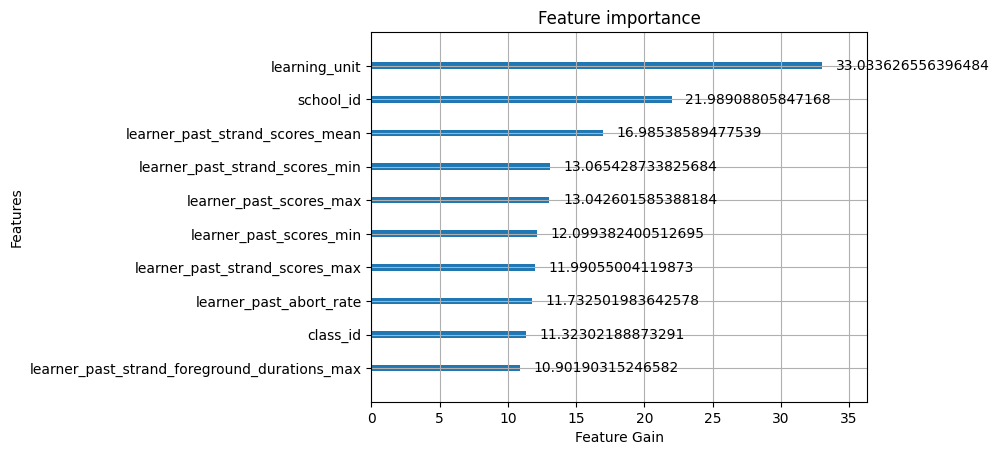

In [101]:
# %%

(train_feature_df, train_labels), (val_feature_df, val_labels), (test_feature_df, test_labels) = _prepare_datasets(
    [train_activity_df, val_activity_df, test_activity_df],
    categorical_columns,
    numerical_columns,
    label_column="score_bin",
)
classifier = xgb.XGBClassifier(enable_categorical=True, validate_parameters=True)
param_grid = {
    "max_depth": [1, 2],  # low values prevent overfitting
    "n_estimators": [10, 50],  # low values prevent overfitting
    "subsample": [0.8],
    "min_child_weight": [0, 1, 2, 5, 10, 20],  # high values prevent overfitting
    "gamma": [0, 0.2, 1, 2, 5, 10],  # high values prevent overfitting
    "learning_rate": [0.05, 0.1],
    "max_bin": [128],
    "max_cat_to_onehot": [5],
}
param_combinations = math.prod([len(param) for param in param_grid.values()])
print(f"Number of combinations: {param_combinations}")
print(f"Estimated time: {param_combinations*2/60} minutes")

clf = _run_grid_search(
    xbg_model=classifier,
    param_grid=param_grid,
    train_feature_df=train_feature_df,
    val_feature_df=val_feature_df,
    train_labels=train_labels,
    val_labels=val_labels,
    scoring="f1_weighted",
)
print("best_params:", clf.best_params_)
classifier = clf.best_estimator_

xgb.plot_importance(
    clf.best_estimator_.get_booster(),
    max_num_features=10,
    importance_type="gain",
    xlabel="Feature Gain",
)

In [102]:
# %%
cv_result_df = pd.DataFrame(clf.cv_results_)
param_columns = [
    column for column in cv_result_df.columns if column.startswith("param_") and column != "param_tree_method"
]
score_columns = ["mean_train_score", "mean_test_score"]
cv_result_df[[*param_columns, *score_columns]].corr()[score_columns]

,mean_train_score,mean_test_score
param_gamma,-0.043402,-0.010013
param_learning_rate,0.231056,0.186600
param_max_bin,NaN,NaN
param_max_cat_to_onehot,NaN,NaN
param_max_depth,0.573909,0.491592
param_min_child_weight,-0.484132,-0.417540
param_n_estimators,0.527662,0.448178
param_subsample,NaN,NaN
mean_train_score,1.000000,0.919878
mean_test_score,0.919878,1.000000


In [104]:
# %%
def _print_classification_metrics(pred_labels, true_labels, label_names, split_name):
    precision = precision_score(true_labels, pred_labels, average=None)
    recall = recall_score(true_labels, pred_labels, average=None)
    f1_weighted = f1_score(true_labels, pred_labels, average="weighted")

    label_names = np.array(label_names)[np.unique(true_labels)]
    print(f"{split_name} precision for each label:")
    print(pd.DataFrame(precision, index=label_names, columns=["precision"]))
    print(f"{split_name} recall for each label:")
    print(pd.DataFrame(recall, index=label_names, columns=["recall"]))
    print(f"{split_name} f1-score weighted:", f1_weighted)
    print()


for feature_df, true_labels, name in [
    (train_feature_df, train_labels, "train"),
    (val_feature_df, val_labels, "val"),
    (test_feature_df, test_labels, "test"),
]:
    pred_labels = classifier.predict(feature_df)
    _print_classification_metrics(pred_labels, true_labels, label_names=bin_labels, split_name=name)

train precision for each label:
           precision
0.00-0.04   0.555911
0.04-0.40   0.588483
0.40-0.75   0.504525
0.75-1.00   0.587515
train recall for each label:
             recall
0.00-0.04  0.455497
0.04-0.40  0.542044
0.40-0.75  0.577720
0.75-1.00  0.657534
train f1-score weighted: 0.5553151216200027

val precision for each label:
           precision
0.00-0.04   0.382609
0.04-0.40   0.478261
0.40-0.75   0.267857
0.75-1.00   0.531915
val recall for each label:
             recall
0.00-0.04  0.366667
0.04-0.40  0.539216
0.40-0.75  0.250000
0.75-1.00  0.510204
val f1-score weighted: 0.42947407206096566

test precision for each label:
           precision
0.00-0.04   0.487179
0.04-0.40   0.458065
0.40-0.75   0.390244
0.75-1.00   0.582090
test recall for each label:
             recall
0.00-0.04  0.398601
0.04-0.40  0.682692
0.40-0.75  0.280702
0.75-1.00  0.513158
test f1-score weighted: 0.4731213036100254



 Train and validation RMSE are close, which means we are not overfitting but, similar to the regression model,
 classification performance is not great. Let's see if any of the learning units has particular good performance.

In [106]:
for learning_unit in sorted(activity_df.learning_unit.unique()):
    lu_test_samples_index = test_feature_df[test_feature_df.learning_unit == learning_unit].index

    lu_test_feature_df = test_feature_df.loc[list(lu_test_samples_index)]
    lu_test_labels = test_labels.loc[list(lu_test_samples_index)]

    pred_labels = classifier.predict(lu_test_feature_df)

    f1_weighted = f1_score(pred_labels, lu_test_labels, average="weighted")
    print(f"learning_unit={learning_unit} (n={len(lu_test_labels)}) f1-score: {f1_weighted}")

learning_unit=OneCourse:OC_PhraseSentenceType.4dd8 (n=21) f1-score: 0.7936507936507937
learning_unit=OneCourse:OC_PhraseSentenceType.5d44 (n=16) f1-score: 0.6889952153110047
learning_unit=OneCourse:OC_PhraseSentenceType.5dd1 (n=48) f1-score: 0.4698232323232323
learning_unit=OneCourse:OC_PhraseSentenceType.71cf (n=31) f1-score: 0.6787030518862064
learning_unit=OneCourse:OC_PhraseSentenceType.7864 (n=69) f1-score: 0.45349218046344053
learning_unit=OneCourse:OC_PhraseSentenceType.9b09 (n=17) f1-score: 0.5
learning_unit=OneCourse:OC_PhraseSentenceType.df02 (n=29) f1-score: 0.416564039408867
learning_unit=OneCourse:OC_TalkingHead.1dac (n=18) f1-score: 0.703166935050993
learning_unit=OneCourse:OC_TalkingHead.2360 (n=21) f1-score: 0.40192743764172334
learning_unit=OneCourse:OC_TalkingHead.23de (n=25) f1-score: 0.5333333333333333
learning_unit=OneCourse:OC_TalkingHead.3dba (n=15) f1-score: 0.6956521739130435
learning_unit=OneCourse:OC_TalkingHead.5352 (n=26) f1-score: 0.5352226720647774
learni

 ### TabNet as a classifier

In [107]:
(train_samples, train_labels), (val_samples, val_labels), (test_samples, test_labels) = _prepare_tabnet_datasets(
    train_activity_df,
    val_activity_df,
    test_activity_df,
    categorical_columns=categorical_columns,
    numerical_columns=numerical_columns,
    label_column="score_bin",
)
classifier = TabNetClassifier(verbose=0)
_fit_tabnet(
    tabnet_model=classifier,
    train_samples=train_samples,
    val_samples=val_samples,
    train_labels=train_labels,
    val_labels=val_labels,
    eval_metric="logloss",
    # unsupervised_model=unsupervised_model,
)


Early stopping occurred at epoch 23 with best_epoch = 13 and best_val_logloss = 1.60406


/opt/miniconda3/envs/eidu/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [108]:
# %%

for feature_df, true_labels, name in [
    (train_samples, train_labels, "train"),
    (val_samples, val_labels, "val"),
    (test_samples, test_labels, "test"),
]:
    pred_labels = classifier.predict(feature_df)
    _print_classification_metrics(pred_labels, true_labels, label_names=bin_labels, split_name=name)

train precision for each label:
           precision
0.00-0.04   0.357955
0.04-0.40   0.285294
0.40-0.75   0.287904
0.75-1.00   0.250000
train recall for each label:
             recall
0.00-0.04  0.247382
0.04-0.40  0.250970
0.40-0.75  0.681347
0.75-1.00  0.001370
train f1-score weighted: 0.24495315944717197

val precision for each label:
           precision
0.00-0.04   0.302564
0.04-0.40   0.271186
0.40-0.75   0.215385
0.75-1.00   0.500000
val recall for each label:
             recall
0.00-0.04  0.491667
0.04-0.40  0.313725
0.40-0.75  0.233333
0.75-1.00  0.010204
val f1-score weighted: 0.23690817953975846

test precision for each label:
           precision
0.00-0.04   0.331461
0.04-0.40   0.292517
0.40-0.75   0.272727
0.75-1.00   0.000000
test recall for each label:
             recall
0.00-0.04  0.412587
0.04-0.40  0.413462
0.40-0.75  0.263158
0.75-1.00  0.000000
test f1-score weighted: 0.27228500387226773



/opt/miniconda3/envs/eidu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


 TabNet as a classifier still does not beat XGBoost. Authors of the model claim it consistenly outperforms it.

 There was not enough time to tune the model further, but it's possible that with more time, TabNet could outperform XGBoost.

In [ ]:
# %%